## CartPole

In this basic reinforcement learning agent example, the goal is to keep the pole upright, for some number of steps/frames. The environment will fail if the pole reaches some max angle, or the cart reaches the far left or right sides. See more at [openai.com](https://gym.openai.com/envs/CartPole-v0/).

*Observations*

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

*Actions*

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import gym
from helpers import output_folder, display_frames_as_video, QAgent
from gym import wrappers, logger
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [2]:
logger.set_level(logger.INFO)
np.set_printoptions(threshold=np.nan) # dont ellide matrices
MAX_EPISODE_REWARD = 300 # 200 is the usual "complete" game
# env = wrappers.Monitor(env_, directory=output_folder('cartpole-'), force=True)

### Randomized linear model

This initial solver of CartPole is from [Kevin Frans](http://kvfrans.com/simple-algoritms-for-solving-cartpole/) who employs a simple linear model for the solution of moving left or right.

First, we define a function which simple runs an episode of cartpole until it finishes, reaching either max reward or the pole falling over. Then randomly generate parameters and try them out. If the run improves on the previous best, save those parameters. Rinse and repeat until the max score is reached.

In [3]:
def run_episode(env, params, count, render=False):
    total = 0
    frames = []
    for _ in range(count):
        observation = env.reset()
        for t in range(MAX_EPISODE_REWARD):
            if render:
                frames.append(env.render(mode = 'rgb_array'))
            action = 0 if np.matmul(params, observation) < 0 else 1
            observation, reward, done, info = env.step(action)
            total += reward
            if done:
                break
    if render:
        return (total / count, frames)
    return total / count

def random_linear_model(run_count):
    best_params = None  
    best_reward = 0  
    for _ in range(10000): # assume we'll not need more then n attempts
        params = np.random.rand(4) * 2 - 1
        reward = run_episode(env, params, run_count)
        if reward > best_reward:
            best_reward = reward
            best_params = params
            if reward == MAX_EPISODE_REWARD:
                break
    return (best_params, _)

INFO: Making new env: CartPole-v1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Median guesses => 29.0


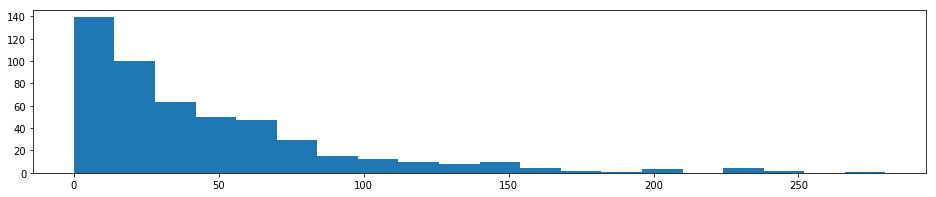

In [4]:
env = gym.make('CartPole-v1')
iteration_counts = []
# run for a bunch of times to see how good this method is
for _ in range(100):
    params, c = random_linear_model(10)
    iteration_counts.append(c)

print(f'Median guesses => {np.median(iteration_counts)}')
plt.figure(figsize=(16, 3))
plt.hist(iteration_counts, bins=20)
plt.show()

In [5]:
_, frames = run_episode(env, params, 1, render=True)
display_frames_as_video(frames)
env.close()

## Q-Learning

Implementation from [YuriGuts](https://github.com/YuriyGuts/cartpole-q-learning/blob/master/cartpole.py)

In [6]:
class CartPoleAgent(QAgent):
    def get_state_bins(self):
        num_discretization_bins = 7
        return [
            # Cart position.
            self._discretize_range(-2.4, 2.4, num_discretization_bins),
            # Cart velocity.
            self._discretize_range(-3.0, 3.0, num_discretization_bins),
            # Pole angle.
            self._discretize_range(-0.5, 0.5, num_discretization_bins),
            # Tip velocity.
            self._discretize_range(-2.0, 2.0, num_discretization_bins)
        ]
    def get_environment(self):
        return gym.make('CartPole-v1')

In [7]:
qagent = CartPoleAgent(
    learning_rate=0.05,
    discount_factor=0.95,
    exploration_rate=0.5,
    exploration_decay_rate=0.99,
    num_of_actions=2
)

print(f'State bin shapes: [{qagent._state_bins[0].shape} , ' +
      f'{qagent._state_bins[1].shape}, {qagent._state_bins[2].shape}, {qagent._state_bins[3].shape}]')
print(f'Q shape: {qagent.q.shape}')

agent_success, episodes = qagent.train()
print(f'{"Solved" if agent_success else "Not solved"} after {episodes} episodes')

_, frames = qagent.run(render=True)
display_frames_as_video(frames)

State bin shapes: [(6,) , (6,), (6,), (6,)]
Q shape: (2401, 2)
INFO: Making new env: CartPole-v1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


C:\Users\svto\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\svto\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Solved after 446 episodes
INFO: Making new env: CartPole-v1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
